In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision
import torchvision.models as models
from torchsummary import summary

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
batch_size = 64
train_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616]),
    ])

val_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616])
    ])

train_set = CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=train_transform
)

val_set = CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=val_transform
)

trainloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

testloader = DataLoader(
    val_set, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4,
)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [3]:
import timm

model = timm.create_model("convnext_tiny", pretrained=False)
model.head.fc = nn.Linear(in_features=768, out_features=10)

/home/server-96gb-ailab/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model = model.to(device)

In [5]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
          Identity-3           [-1, 96, 56, 56]               0
            Conv2d-4           [-1, 96, 56, 56]           4,800
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
           Dropout-8          [-1, 56, 56, 384]               0
          Identity-9          [-1, 56, 56, 384]               0
           Linear-10           [-1, 56, 56, 96]          36,960
          Dropout-11           [-1, 56, 56, 96]               0
              Mlp-12           [-1, 56, 56, 96]               0
         Identity-13           [-1, 96, 56, 56]               0
         Identity-14           [-1, 96,

# Train

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)  

In [7]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [8]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 30

In [9]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{(epoch + 1):3}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.2f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [  1/ 30] 	 Loss: 1.67855     Accuracy: 38.75% 	 Test Loss: 1.45560     Test Accuracy: 47.10%
Epoch [  2/ 30] 	 Loss: 1.24973     Accuracy: 54.59% 	 Test Loss: 1.11349     Test Accuracy: 60.13%
Epoch [  3/ 30] 	 Loss: 1.01509     Accuracy: 63.74% 	 Test Loss: 0.92605     Test Accuracy: 67.12%
Epoch [  4/ 30] 	 Loss: 0.83502     Accuracy: 70.19% 	 Test Loss: 0.84536     Test Accuracy: 70.25%
Epoch [  5/ 30] 	 Loss: 0.67976     Accuracy: 76.17% 	 Test Loss: 0.72201     Test Accuracy: 74.56%
Epoch [  6/ 30] 	 Loss: 0.55287     Accuracy: 80.51% 	 Test Loss: 0.72084     Test Accuracy: 75.09%
Epoch [  7/ 30] 	 Loss: 0.44808     Accuracy: 84.27% 	 Test Loss: 0.64899     Test Accuracy: 77.76%
Epoch [  8/ 30] 	 Loss: 0.34427     Accuracy: 87.85% 	 Test Loss: 0.67019     Test Accuracy: 78.48%
Epoch [  9/ 30] 	 Loss: 0.25630     Accuracy: 90.80% 	 Test Loss: 0.67400     Test Accuracy: 79.66%
Epoch [ 10/ 30] 	 Loss: 0.19503     Accuracy: 92.98% 	 Test Loss: 0.75989     Test Accuracy: 78.74%


In [10]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%")


Best epoch: 19 with test accuracy: 81.09%


# Plot results

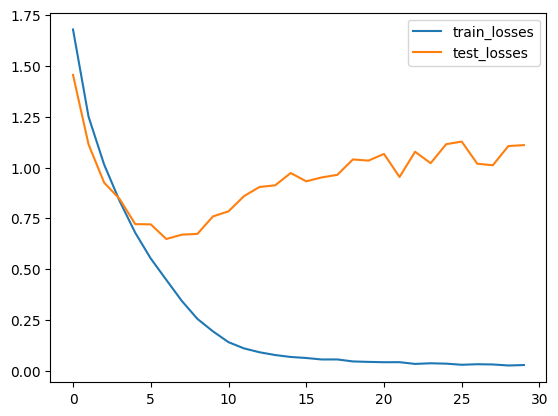

In [11]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

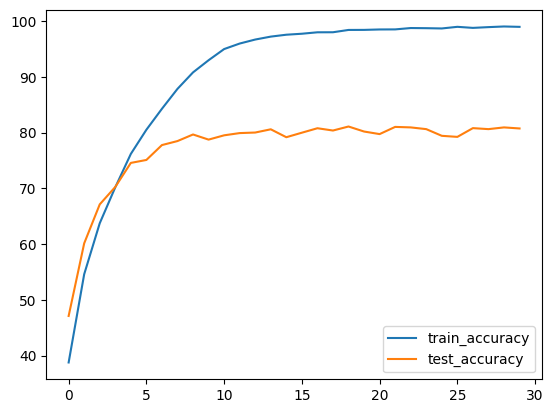

In [12]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()